In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurolib.models.multimodel import MultiModel

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
from neurolib.models.multimodel.builder.aln import (
    ALN_EXC_DEFAULT_PARAMS,
    ALN_INH_DEFAULT_PARAMS,
    ALN_NODE_DEFAULT_CONNECTIVITY,
    ALN_NODE_DEFAULT_DELAYS,
    ALNNode,
)
from neurolib.models.multimodel.builder.base.constants import EXC, INH
from neurolib.models.multimodel.builder.base.network import Network
from neurolib.models.multimodel.builder.thalamus import (
    TCR_DEFAULT_PARAMS,
    THALAMUS_NODE_DEFAULT_CONNECTIVITY,
    TRN_DEFAULT_PARAMS,
    ThalamicNode,
)


class ALNThalamusMiniNetwork(Network):
    """
    Simple thalamo-cortical motif: 1 node cortical ALN + 1 node NMM thalamus.
    """

    name = "ALN 1 node + Thalamus"
    label = "ALNThlmNet"

    sync_variables = [
        "network_exc_exc",
        "network_exc_exc_sq",
        "network_inh_exc",
    ]

    default_output = f"r_mean_{EXC}"
    output_vars = [f"r_mean_{EXC}", f"r_mean_{INH}", f"I_A_{EXC}"]

    def __init__(
        self,
        connectivity_matrix,
        delay_matrix,
        thalamus_exc_inh_multiplier=1.0,
        exc_aln_params=ALN_EXC_DEFAULT_PARAMS,
        inh_aln_params=ALN_INH_DEFAULT_PARAMS,
        aln_node_connectivity=ALN_NODE_DEFAULT_CONNECTIVITY,
        aln_node_delays=ALN_NODE_DEFAULT_DELAYS,
        tcr_params=TCR_DEFAULT_PARAMS,
        trn_params=TRN_DEFAULT_PARAMS,
        thalamus_node_connectivity=THALAMUS_NODE_DEFAULT_CONNECTIVITY,
    ):
        assert np.all(np.diag(connectivity_matrix) == 0.0)

        # init ALN node with index 0
        aln_node = ALNNode(
            exc_params=exc_aln_params,
            inh_params=inh_aln_params,
            connectivity=aln_node_connectivity,
            delays=aln_node_delays,
        )
        aln_node.index = 0
        aln_node.idx_state_var = 0
        # set correct indices of noise input - one per mass
        for mass in aln_node:
            mass.noise_input_idx = [mass.index]

        # init thalamus node with index 1
        thalamus = ThalamicNode(
            tcr_params=tcr_params,
            trn_params=trn_params,
            connectivity=thalamus_node_connectivity,
        )
        thalamus.index = 1
        thalamus.idx_state_var = aln_node.num_state_variables
        # set correct indices of noise input - one per mass, after ALN noise
        # indices
        for mass in thalamus:
            mass.noise_input_idx = [aln_node.num_noise_variables + mass.index]

        # init network with these two nodes
        super().__init__(
            nodes=[aln_node, thalamus],
            connectivity_matrix=connectivity_matrix,
            delay_matrix=delay_matrix,
        )
        # assert we have 3 sync variables - network exc -> exc (for both),
        # network exc -> exc squared (for ALN), and network exc -> inh
        # (for thalamus)
        assert len(self.sync_variables) == 3
        self.thalamus_exc_inh_mult = thalamus_exc_inh_multiplier

    def _sync(self):
            """
            Set coupling variables.
            """
            # get indices of coupling variables from all nodes
            exc_indices = [
                next(
                    iter(
                        node.all_couplings(
                            mass_indices=node.excitatory_masses.tolist()
                        )
                    )
                )
                for node in self
            ]
            assert len(exc_indices) == len(self)

            return (
                # basic EXC <-> EXC coupling
                self._additive_coupling(
                    within_node_idx=exc_indices, symbol="network_exc_exc"
                )
                # squared EXC <-> EXC coupling (only to ALN)
                + self._additive_coupling(
                    within_node_idx=exc_indices,
                    symbol="network_exc_exc_sq",
                    connectivity=self.connectivity * self.connectivity,
                )
                # EXC -> INH coupling (only to thalamus)
                + self._additive_coupling(
                    within_node_idx=exc_indices,
                    symbol="network_inh_exc",
                    connectivity=self.connectivity * self.thalamus_exc_inh_mult,
                )
                + super()._sync()
            )

/home/lena/.local/lib/python3.9/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/tmp/tmpmuor_890/jitced_16.c: In function ‘get_past_anchors’:
/tmp/tmpmuor_890/jitced_16.c:176: warning: ignoring ‘#pragma omp atomic’ [-Wunknown-pragmas]
  176 |         #pragma omp atomic capture
      | 
/tmp/tmpmuor_890/jitced_16.c:190: warning: ignoring ‘#pragma omp critical’ [-Wunknown-pragmas]
  190 |                 #pragma omp critical(pws)
      | 
/tmp/tmpmuor_890/jitced_16.c: In function ‘get_recent_state’:
/tmp/tmpmuor_890/jitced_16.c:285: warning: ignoring ‘#pragma omp parallel’ [-Wunknown-pragmas]
  285 |         #pragma omp parallel for schedule(dynamic, 1)
      | 
In file

Using default integration parameters.


  0%|          | 0/10000 [00:00<?, ?it/s]/home/lena/.local/lib/python3.9/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
100%|██████████| 10000/10000 [00:00<00:00, 18657.16it/s]


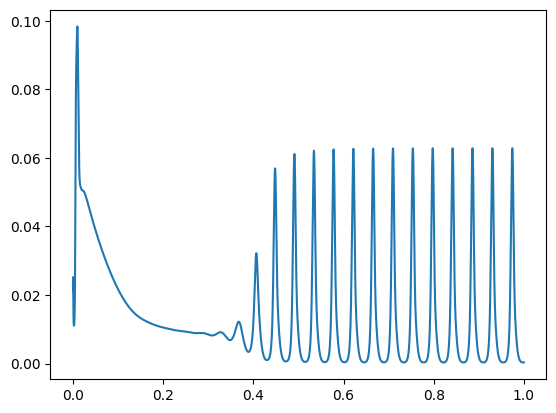

In [14]:
model = MultiModel(ALNThalamusMiniNetwork(
            np.array([[0.0, 0.], [0., 0.0]]),
            np.array([[0.0, 0.], [0., 0.0]]),
        )
    )

#model.params["*g_LK"] = 0.032 # K-leak conductance in thalamus
#model.params["ALNThlmNet.ALNNode_0.ALNMassEXC_0.a"] = 0.0 # no firing rate adaptation
#model.params["*b"] = 15.0 # spike adaptation
#model.params["*tauA"] = 1000.0 # slow adaptation timescale
model.params["*EXC*mu"] = 3. # background excitation to ALN
#model.params["*INH*mu"] = 3.5 # background inhibition to ALN
model.params["*ALNMass*input*sigma"] = 0.0
model.params["*TCR*input*sigma"] = 0.0
#model.params["*input*tau"] = 5.0 # timescale of OU process

# number low for testing:
model.params["duration"] = 1000. 
model.run()

plt.plot(model.t, model.r_mean_EXC[0, :].T)
plt.show()


In [15]:

model.params["ALNThlmNet.ALNNode_0.ALNMassEXC_0.ext_exc_current"] = 5. * np.ones((int(model.params.duration/model.params.dt)))
#model.params["*ALNMass*ext_exc_current"] = 5.
model.run()

plt.plot(model.t, model.r_mean_EXC[0, :].T)
plt.show()

# nicht:
# model.params["*ALNMass*input*ext_exc_current"] = 5.

/home/lena/.local/lib/python3.9/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")


SympifyError: sympy2symengine: Cannot convert 'array([(5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0)))),
       (5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0)))),
       (5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0)))),
       ...,
       (5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0)))),
       (5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0)))),
       (5.0 - current_y(0) + 2.43*current_y(2) - 3.3*current_y(3) + past_y(-external_input + t, input_base_n, anchors(-external_input + t)))/tau_lookup(current_y(0) - 0.005*current_y(1), sqrt(2.25 + 472.392*current_y(4)/(2.0 + 20.0*(1.0 + 82.3045267489712*network_exc_exc_0 + 800.0*node_exc_exc_0)) + 2178.0*current_y(5)/(5.0 + 20.0*(1.0 + 200.0*node_exc_inh_0))))],
      dtype=object)' (of type <class 'numpy.ndarray'>) to a symengine type.